In [3]:
import pandas as pd
df = pd.read_parquet("data/intermediate/discogs_tmdb_candidates_extended.parquet")
print(df.columns.tolist())
print(df.head(3))


['movie_ref', 'discogs_title_norm', 'tmdb_title_norm', 'discogs_year', 'tmdb_year', 'discogs_genre', 'tmdb_genre', 'discogs_style']
   movie_ref                                 discogs_title_norm  \
0  Star Wars  john williams the london symphony orchestra st...   
1  Star Wars  john williams the london symphony orchestra st...   
2  Star Wars  john williams the london symphony orchestra st...   

                          tmdb_title_norm discogs_year tmdb_year  \
0                               star wars         1977      1977   
1  criaturas de la guerra de las galaxias         1977      2006   
2             dans ombre du star wars kid         1977      2022   

               discogs_genre tmdb_genre                    discogs_style  
0  Classical, Stage & Screen             Soundtrack, Score, Neo-Romantic  
1  Classical, Stage & Screen             Soundtrack, Score, Neo-Romantic  
2  Classical, Stage & Screen             Soundtrack, Score, Neo-Romantic  


In [5]:
import pandas as pd
df = pd.read_parquet("data/intermediate/discogs_tmdb_matches.parquet")
print(df.sort_values("score", ascending=False).head(10))


                     movie_ref  \
0   E.T. the Extra-Terrestrial   
11          Return of the Jedi   
24     The Empire Strikes Back   
21     The Empire Strikes Back   
19     The Empire Strikes Back   
16     The Empire Strikes Back   
15                   Star Wars   
14                   Star Wars   
12                   Star Wars   
13                   Star Wars   

                                   discogs_title_norm      tmdb_title_norm  \
0                drew barrymore the extra terrestrial    extra terrestrial   
11                  unknown artist return of the jedi   return of the jedi   
24  london symphony orchestra the story of the emp...  empire strikes back   
21  john williams the london symphony orchestra st...  empire strikes back   
19   unknown artist star wars the empire strikes back  empire strikes back   
16  john williams the london symphony orchestra st...  empire strikes back   
15  john williams the london symphony orchestra st...            star wars   
1

In [7]:
import pandas as pd

df = pd.read_parquet("data/intermediate/discogs_tmdb_matches.parquet")

top_pairs = (
    df.sort_values("score", ascending=False)
      .loc[:, ["movie_ref", "discogs_title_norm", "tmdb_title_norm",
               "discogs_year", "tmdb_year", "score"]]
)

print("💍 Top Discogs ↔ TMDB matches:")
display(top_pairs.head(10))


💍 Top Discogs ↔ TMDB matches:


,movie_ref,discogs_title_norm,tmdb_title_norm,discogs_year,tmdb_year,score
0,E.T. the Extra-Terrestrial,drew barrymore the extra terrestrial,extra terrestrial,1983,1982,90.0
11,Return of the Jedi,unknown artist return of the jedi,return of the jedi,1983,1983,90.0
24,The Empire Strikes Back,london symphony orchestra the story of the emp...,empire strikes back,1983,1980,90.0
21,The Empire Strikes Back,john williams the london symphony orchestra st...,empire strikes back,1980,1980,90.0
19,The Empire Strikes Back,unknown artist star wars the empire strikes back,empire strikes back,1980,1980,90.0
16,The Empire Strikes Back,john williams the london symphony orchestra st...,empire strikes back,1980,1980,90.0
15,Star Wars,john williams the london symphony orchestra st...,star wars,1977,1977,90.0
14,Star Wars,unknown artist star wars,star wars,1979,1977,90.0
12,Star Wars,john williams the london symphony orchestra st...,star wars,1977,1977,90.0
13,Star Wars,original cast with narration by roscoe lee bro...,star wars,1977,1977,90.0


In [9]:
df["score_bin"] = (df["score"] // 10) * 10
score_summary = (
    df.groupby("score_bin")
      .agg(matches=("score", "count"))
      .reset_index()
)
display(score_summary)
print("Mean fuzzy score:", round(df["score"].mean(), 2))
print("Median fuzzy score:", round(df["score"].median(), 2))


,score_bin,matches
0,80.0,14
1,90.0,13


Mean fuzzy score: 87.67
Median fuzzy score: 85.5


In [19]:
import pandas as pd

# Safely coerce year columns to numeric
df["discogs_year"] = pd.to_numeric(df["discogs_year"], errors="coerce")
df["tmdb_year"]    = pd.to_numeric(df["tmdb_year"], errors="coerce")

# Compute absolute year gap
df["year_gap"] = (df["discogs_year"] - df["tmdb_year"]).abs()

# Inspect summary
print(df["year_gap"].describe())

# Show potential mismatches
print(df[df["year_gap"] > 2][["movie_ref", "discogs_year", "tmdb_year", "score"]])


count    22.000000
mean      0.545455
std       1.100964
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       3.000000
Name: year_gap, dtype: float64
                  movie_ref  discogs_year  tmdb_year  score
24  The Empire Strikes Back          1983     1980.0   90.0
25  The Empire Strikes Back          1983     1980.0   85.5
26  The Empire Strikes Back          1983     1980.0   85.5


In [13]:
genre_check = (
    df.assign(match_genre=lambda x:
              x["discogs_genre"].str.contains("Soundtrack", case=False)
              & x["tmdb_genre"].str.contains("Soundtrack", case=False))
)
print("Soundtrack-tag alignment rate:",
      genre_check["match_genre"].mean().round(2))


Soundtrack-tag alignment rate: 0.0


In [15]:
total_titles = df["movie_ref"].nunique()
strong = (df["score"] >= 90).sum()
print(f"❤️  {strong} / {len(df)} matches ≥ 90 ({strong/len(df):.1%})")
print(f"🎬  {total_titles} unique titles linked across Discogs + TMDB")


❤️  13 / 27 matches ≥ 90 (48.1%)
🎬  5 unique titles linked across Discogs + TMDB


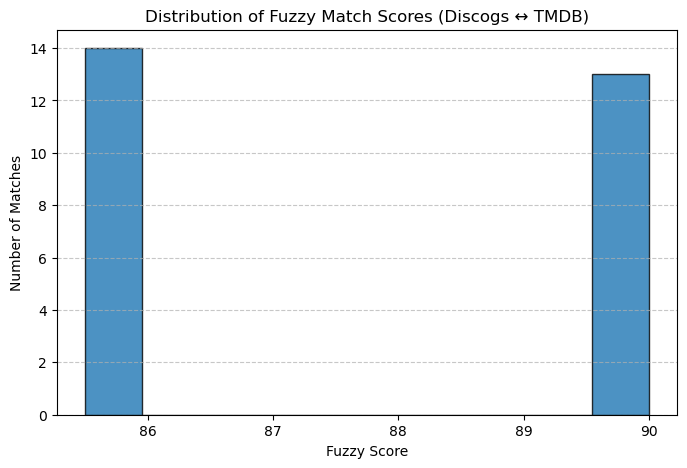

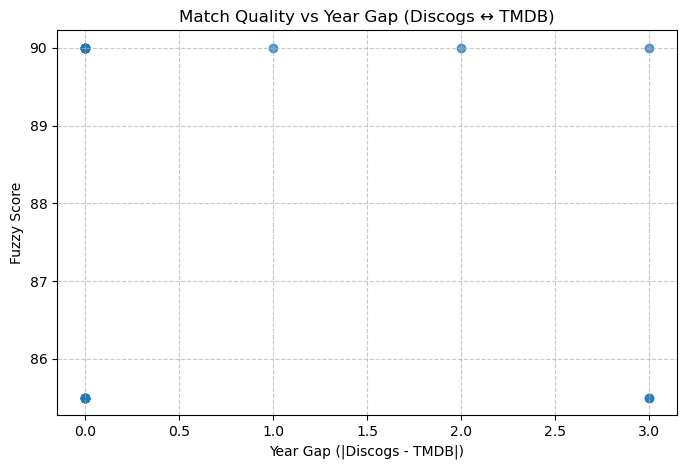

In [21]:
# --- Step 04 Visualization: Fuzzy Match Quality ---
import pandas as pd
import matplotlib.pyplot as plt

# Load the Step 04 matches parquet
df = pd.read_parquet("data/intermediate/discogs_tmdb_matches.parquet")

# Coerce years safely
df["discogs_year"] = pd.to_numeric(df["discogs_year"], errors="coerce")
df["tmdb_year"]    = pd.to_numeric(df["tmdb_year"], errors="coerce")
df["year_gap"]     = (df["discogs_year"] - df["tmdb_year"]).abs()

# --- Histogram of fuzzy match scores ---
plt.figure(figsize=(8, 5))
plt.hist(df["score"], bins=10, edgecolor="black", alpha=0.8)
plt.title("Distribution of Fuzzy Match Scores (Discogs ↔ TMDB)")
plt.xlabel("Fuzzy Score")
plt.ylabel("Number of Matches")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# --- Scatter plot of year gap vs fuzzy score ---
plt.figure(figsize=(8, 5))
plt.scatter(df["year_gap"], df["score"], alpha=0.7)
plt.title("Match Quality vs Year Gap (Discogs ↔ TMDB)")
plt.xlabel("Year Gap (|Discogs - TMDB|)")
plt.ylabel("Fuzzy Score")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()
